In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import sqlite3 as lite
from matplotlib.patches import Polygon, PathPatch
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import math
from IPython.display import Image
con = lite.connect('census')
#data.to_sql(name='censusHH',con=con, if_exists ='append')

In [5]:
#Standard deviation UDF for sqlite3
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
with con:
 
    con.create_aggregate("stdev", 1, StdevFunc)
 
    cur = con.cursor()

plot.py:110: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  pc.set_color(blues[bucket])


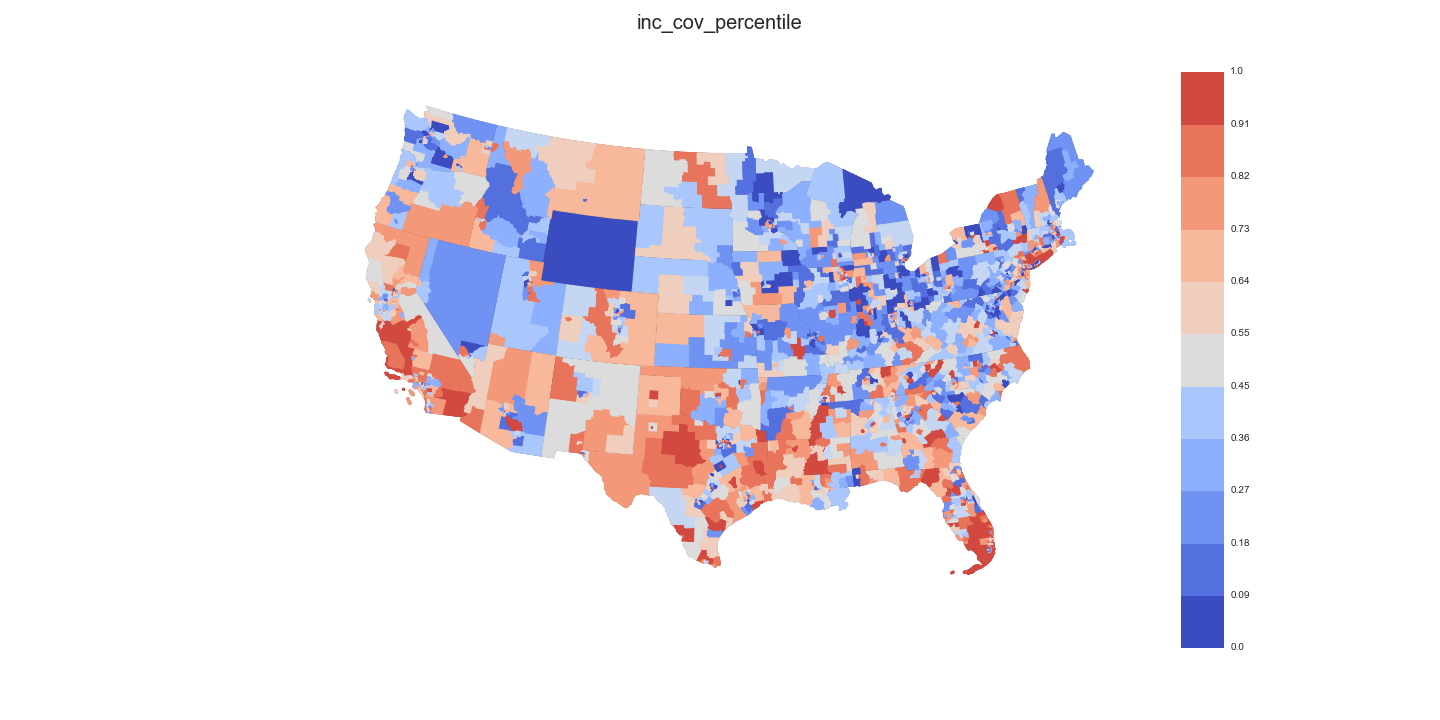

In [6]:
#Coefficient of variance in income per PUMA. Higher value = higher income inequality
inc_cov = pd.read_sql('select stdev(PINCP)/avg(PINCP) value, ST, PUMA \
from censusPerson group by  ST, PUMA',con=con)
inc_cov['value']=inc_cov['value'].rank(ascending=True)/inc_cov['value'].count()
inc_cov.to_csv('data-inc_cov.csv',index=False)
%run plot.py data-inc_cov 50 inc_cov_percentile
Image(filename='inc_cov_percentile.png')

Comparing this and the income inequality plot, strange patterns surfaced:  
1. Education doesn't seems to be leveling the income inequality in quite a few places such as New York, South Florida and northen California.  
2. They are both pretty low in the Northwest Pacific area as well as the Great Lakes Metropolis. 
One hypothesis is it has to do with the kind of jobs offered in these areas. The more specific jobs such as science, engineering etc. are more subject to the individual's education while others like management are less dependent on your degrees.

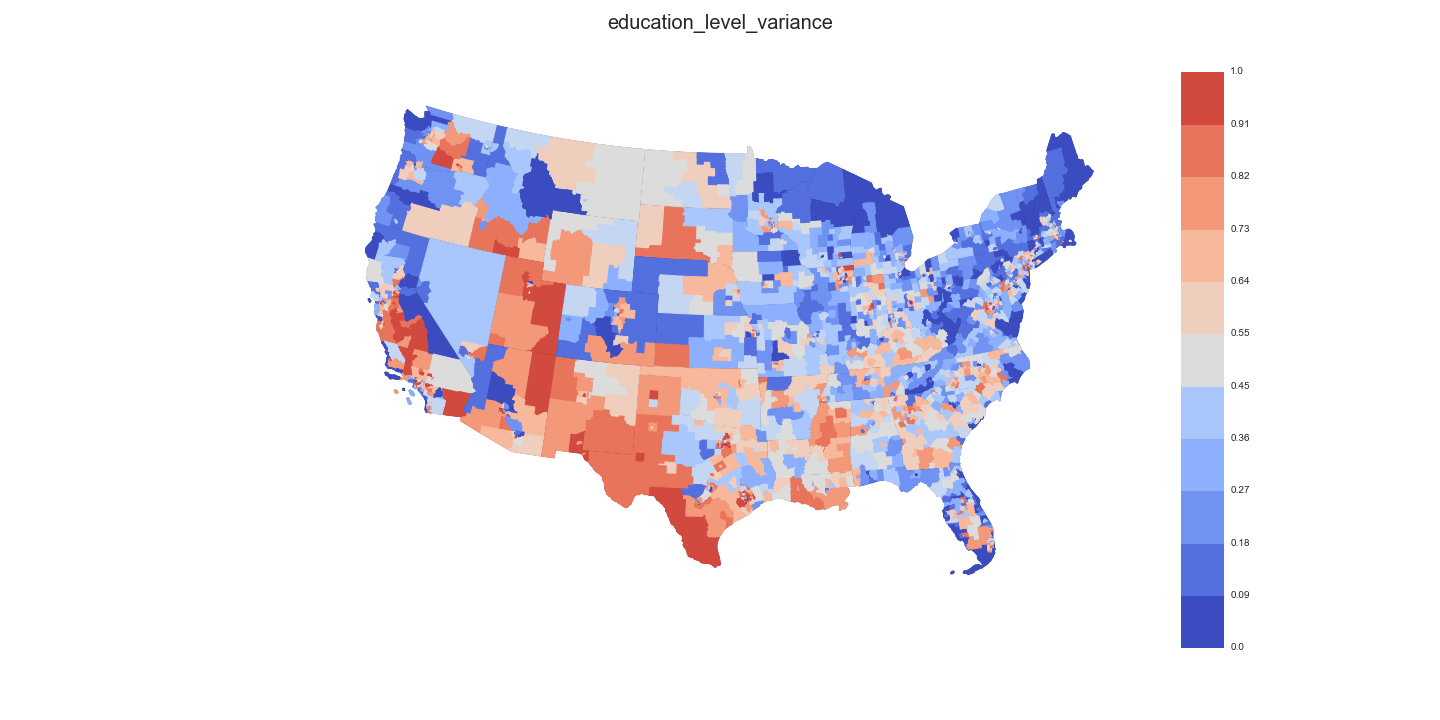

In [176]:
#Coefficient of variance of education levels (1-12, see dict). Higher value = bigger difference in resident's education levels 
edu_var = pd.read_sql('select stdev(SCHL)/avg(SCHL) cov, ST, PUMA \
from censusPerson group by  ST, PUMA',con=con)
edu_var['value']=edu_var['cov'].rank(ascending=True)/edu_var['cov'].count()
edu_var.to_csv('data-edu_var.csv',index=False)
%run plot.py data-edu_var 50 education_level_variance
Image(filename='education_level_variance.png')

plot.py:110: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  pc.set_color(blues[bucket])


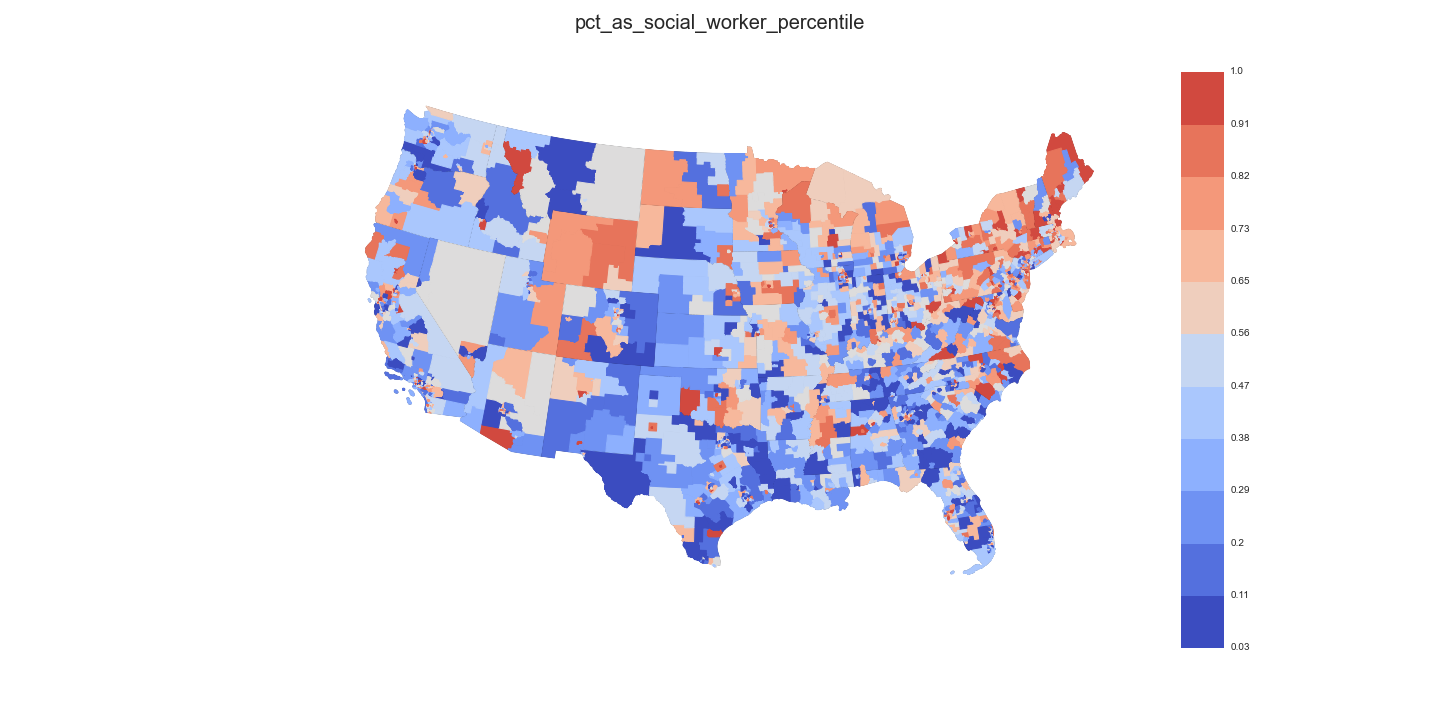

In [7]:
#Percent of residents working as social worker, percentile per PUMA. Higher value = higher social worker per resident
soc_pct = pd.read_sql('select sum(OCCP=2010) soc_worker, count(1) total , ST, PUMA \
from censusPerson group by  ST, PUMA',con=con)
soc_pct['value'] = soc_pct['soc_worker']/soc_pct['total']
soc_pct['value']=soc_pct['value'].rank(ascending=True)/soc_pct['value'].count()
soc_pct.to_csv('data-social.csv',index=False)
%run plot.py data-social 50 pct_as_social_worker_percentile
Image(filename='pct_as_social_worker_percentile.png')

In [66]:
occp_pct = pd.read_sql('''select
sum((OCCP>0 ) * ( OCCP<=0430))*1.0/count(1) MGR,
sum((OCCP>430 ) * ( OCCP<=0740))*1.0/count(1) BUS,
sum((OCCP>740 ) * ( OCCP<=0950))*1.0/count(1) FIN,
sum((OCCP>950 ) * ( OCCP<=1240))*1.0/count(1) CMM,
sum((OCCP>1240 ) * ( OCCP<=1560))*1.0/count(1) ENG,
sum((OCCP>1560 ) * ( OCCP<=1965))*1.0/count(1) SCI,
sum((OCCP>1965 ) * ( OCCP<=2060))*1.0/count(1) CMS,
sum((OCCP>2060 ) * ( OCCP<=2160))*1.0/count(1) LGL,
sum((OCCP>2200 ) * ( OCCP<=2550))*1.0/count(1) EDU,
sum((OCCP>2550 ) * ( OCCP<=2920))*1.0/count(1) ENT,
sum((OCCP>2920 ) * ( OCCP<=3540))*1.0/count(1) MED,
sum((OCCP>3540 ) * ( OCCP<=3655))*1.0/count(1) HLS,
sum((OCCP>3655 ) * ( OCCP<=3955))*1.0/count(1) PRT,
sum((OCCP>3955 ) * ( OCCP<=4150))*1.0/count(1) EAT,
sum((OCCP>4150 ) * ( OCCP<=4250))*1.0/count(1) CLN,
sum((OCCP>4250 ) * ( OCCP<=4650))*1.0/count(1) PRS,
sum((OCCP>4650 ) * ( OCCP<=4965))*1.0/count(1) SAL,
sum((OCCP>4965 ) * ( OCCP<=5940))*1.0/count(1) OFF,
sum((OCCP>5940 ) * ( OCCP<=6130))*1.0/count(1) FFF,
sum((OCCP>6130 ) * ( OCCP<=6765))*1.0/count(1) CON,
sum((OCCP>6765 ) * ( OCCP<=6940))*1.0/count(1) EXT,
sum((OCCP>6940 ) * ( OCCP<=7630))*1.0/count(1) RPR,
sum((OCCP>7630 ) * ( OCCP<=8965))*1.0/count(1) PRD,
sum((OCCP>8965 ) * ( OCCP<=9750))*1.0/count(1) TRN,
sum((OCCP>9750 ) * ( OCCP<=9830))*1.0/count(1) MIL,
sum((OCCP>9830 ) * ( OCCP<=9920))*1.0/count(1) EXT,
 count(1) total , ST, PUMA \
from censusPerson group by  ST, PUMA''',con=con)
#occp_pct['value'] = occp_pct['lawyer']/occp_pct['total']
#occp_pct['value']=lawyer_pct['value'].rank(ascending=True)/lawyer['value'].count()

In [139]:
from sklearn.linear_model import RandomizedLasso
from sklearn.datasets import load_boston
boston = load_boston()
 
#using the Boston housing data. 
#Data gets scaled automatically by sklearn's implementation
X = occp_pct.ix[:,0:25]
Y = inc_cov['value']
names = X.columns
 
#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)
 
print "Features sorted by their rank:"
print zip(map(lambda x: x, rfe.support_), names)

Features sorted by their rank:
[(False, 'BUS'), (False, 'CLN'), (False, 'CMM'), (False, 'CMS'), (False, 'CON'), (False, 'EAT'), (False, 'EDU'), (False, 'ENG'), (False, 'ENT'), (False, 'EXT'), (False, 'FFF'), (False, 'FIN'), (False, 'HLS'), (False, 'LGL'), (False, 'MED'), (False, 'MGR'), (False, 'MIL'), (False, 'OFF'), (False, 'PRD'), (False, 'PRS'), (False, 'PRT'), (False, 'SAL'), (False, 'SCI'), (False, 'TRN'), (True, 'RPR')]


Well, none of the job categories' concentration is well correlated with income inequality.